# **Deep Learning Project: Street View Housing Number Digit Recognition**

# **Marks: 60**

--------------
## **Context** 
--------------

One of the most interesting tasks in deep learning is to recognize objects in natural scenes. The ability to process visual information using machine learning algorithms can be very useful as demonstrated in various applications.

The SVHN dataset contains over 600,000 labeled digits cropped from street-level photos. It is one of the most popular image recognition datasets. It has been used in neural networks created by Google to improve the map quality by automatically transcribing the address numbers from a patch of pixels. The transcribed number with a known street address helps pinpoint the location of the building it represents. 

----------------
## **Objective**
----------------

Our objective is to predict the number depicted inside the image by using Artificial or Fully Connected Feed Forward Neural Networks and Convolutional Neural Networks. We will go through various models of each and finally select the one that is giving us the best performance. 

-------------
## **Dataset**
-------------
Here, we will use a subset of the original data to save some computation time. The dataset is provided as a .h5 file. The basic preprocessing steps have been applied on the dataset.

## **Mount the drive**

Let us start by mounting the Google drive. You can run the below cell to mount the Google drive.

In [1]:
## Using jupyter notebook since Google Colab takes more than 3 hours after using the free computer unites.

## **Importing the necessary libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import h5py
from sklearn.model_selection import train_test_split

# For Data Visualization
import cv2 
import seaborn as sns 

# For Model Building
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, Model # Sequential API for sequential model 
from tensorflow.keras.layers import Dense, Dropout, Flatten # Importing different layers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Activation, Input, LeakyReLU, Activation
from tensorflow.keras import backend 
from tensorflow.keras.utils import to_categorical # To perform one-hot encoding
from tensorflow.keras.optimizers import RMSprop, Adam, SGD # Optimizers for optimizing the model
from tensorflow.keras.callbacks import EarlyStopping  # Regularization method to prevent the overfitting
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import losses, optimizers
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics # also a classidication report
from tensorflow.keras import backend as K

**Let us check the version of tensorflow.**

In [3]:
print(tf.__version__)

2.16.1


## **Load the dataset**

- Let us now load the dataset that is available as a .h5 file.
- Split the data into the train and the test dataset.

In [4]:
# function to check the structure of the .h5 file
def print_structure(name, obj):
    indent = '  ' * (len(name.split('/')) - 1)
    if isinstance(obj, h5py.Dataset):
        print(f"{indent}- Dataset: {name}, shape: {obj.shape}, dtype: {obj.dtype}")
    elif isinstance(obj, h5py.Group):
        print(f"{indent}- Group: {name}")

# specify file path
file_path = '/Users/leon/My Drive/Learning/MIT Data Science/Elective Project/Deep Learning - SVHN Digit Recognition/SVHN_single_grey1.h5'

# check the structure of .h5 file
with h5py.File(file_path, 'r') as h5file:
    # Use the visititems method to traverse the HDF5 file structure
    h5file.visititems(print_structure)


# load the X_val dataset for this project    
with h5py.File(file_path, 'r') as h5file:
    # Read datasets and assign to variables
    X_test = h5file['X_test'][:]
    X_train = h5file['X_train'][:]
    X_val = h5file['X_val'][:]
    y_test = h5file['y_test'][:]
    y_train = h5file['y_train'][:]
    y_val = h5file['y_val'][:]
    
# combine the image with its label into one dataset
df = [(X_val[i], y_val[i]) for i in range(len(X_val))]

- Dataset: X_test, shape: (18000, 32, 32), dtype: float32
- Dataset: X_train, shape: (42000, 32, 32), dtype: float32
- Dataset: X_val, shape: (60000, 32, 32), dtype: float32
- Dataset: y_test, shape: (18000,), dtype: uint8
- Dataset: y_train, shape: (42000,), dtype: uint8
- Dataset: y_val, shape: (60000,), dtype: uint8


In [5]:
# Split to train and test dataset
train_df, test_df = train_test_split(df,test_size = 0.2,random_state = 6)

In [6]:
# Creating the training and testing dataset
X_train = [image for image, label in train_df]
y_train = [label for image, label in train_df]
X_test = [image for image, label in test_df]
y_test = [label for image, label in test_df]

In [7]:
# Transfer into array format
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [8]:
print(f"Number of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")

Number of training samples: 48000
Number of testing samples: 12000


Check the number of images in the training and the testing dataset.

**Observation:**

- There is a total of 60000 images in the dataset.
- After doing a 80-20 spliting, the training dataset has 48000 images, while the testing dataset has 12000 images.

## **Visualizing images**

- Use X_train to visualize the first 10 images.
- Use Y_train to print the first 10 labels.

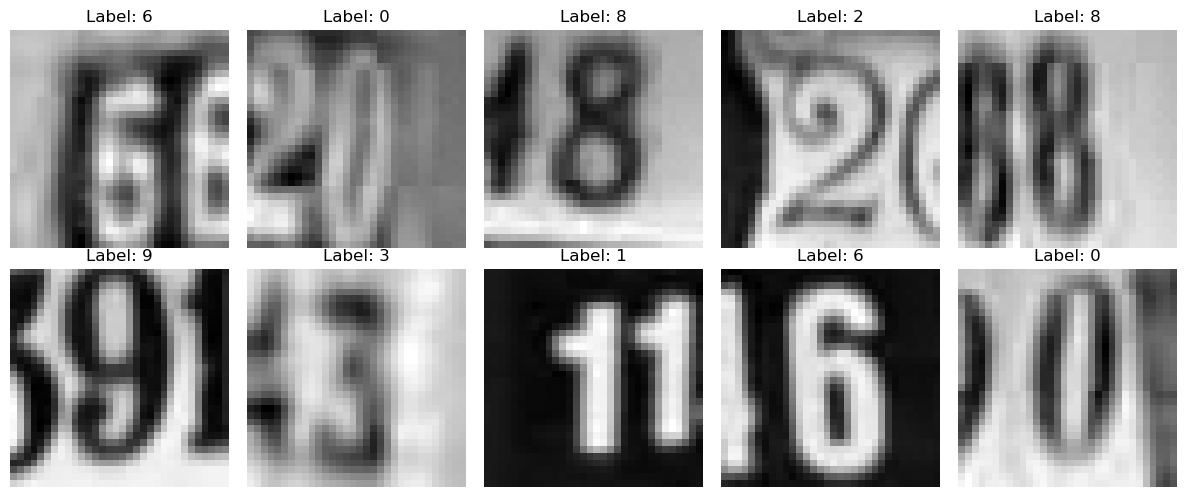

In [9]:
# Visualize the first 10 images with their labels
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(X_train[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Label: {y_train[i]}")

plt.tight_layout()
plt.show()

## **Data preparation**

- Print the shape and the array of pixels for the first image in the training dataset.
- Normalize the train and the test dataset by dividing by 255.
- Print the new shapes of the train and the test dataset.
- One-hot encode the target variable.

In [10]:
first_image_shape = X_train[0].shape
print(f"Shape of the first image: {first_image_shape}")

Shape of the first image: (32, 32)


### **Normalize the train and the test data**

In [11]:
X_train_norm = X_train.astype('float32')/255.0
X_test_norm = X_test.astype('float32')/255.0

Print the shapes of Training and Test data

In [12]:
print(f"Shape of training data: {X_train_norm.shape}")
print(f"Shape of testing data: {y_test.shape}")

Shape of training data: (48000, 32, 32)
Shape of testing data: (12000,)


### **One-hot encode output**

In [13]:
# using to_categorical function from keras.utils
y_train_encode = to_categorical(y_train,num_classes=10).astype('int32')
y_test_encode = to_categorical(y_test,num_classes=10).astype('int32')

**Observation:**
After normalizing the image data, I also reshape it to better usage for the ANN model. Also by checking to result of encode, we also make sure that there are 10 category (0 to 9) in the label dataset.

## **Model Building**

Now that we have done the data preprocessing, let's build an ANN model.

### Fix the seed for random number generators

In [14]:
backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(6)
import random
random.seed(6)
tf.random.set_seed(6)

### **Model Architecture**
- Write a function that returns a sequential model with the following architecture:
 - First hidden layer with **64 nodes and the relu activation** and the **input shape = (1024, )**
 - Second hidden layer with **32 nodes and the relu activation**
 - Output layer with **activation as 'softmax' and number of nodes equal to the number of classes, i.e., 10**
 - Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the nn_model_1 function and store the model in a new variable. 
- Print the summary of the model.
- Fit on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 20**. Store the model building history to use later for visualization.

### **Build and train an ANN model as per the above mentioned architecture.**

In [15]:
# Flatten the images for the input layer
X_train_flattened = X_train_norm.reshape(X_train_norm.shape[0], -1)
X_test_flattened = X_test_norm.reshape(X_test_norm.shape[0], -1)

In [16]:
# Function to clear the Keras backend and set random seeds
def reset_seeds(seed=6):
    K.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

In [17]:
reset_seeds(seed=6)

def nn_model_1():
    model = Sequential()
    model.add(Input(shape=(1024,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32,activation = 'relu'))
    model.add(Dense(10,activation='softmax'))
    
    #compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                 loss = 'categorical_crossentropy',
                 metrics = ['accuracy'])
    return model

model = nn_model_1()
print(model.summary())

# fit the train data
history = model.fit(X_train_flattened, y_train_encode, 
                    validation_split=0.2, 
                    batch_size=128, 
                    epochs=20, 
                    verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,010 (265.66 KB)

 Trainable params: 68,010 (265.66 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 999us/step - accuracy: 0.1064 - loss: 2.3106 - val_accuracy: 0.1538 - val_loss: 2.2622
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.2256 - loss: 2.1475 - val_accuracy: 0.3893 - val_loss: 1.7954
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.4019 - loss: 1.7248 - val_accuracy: 0.4676 - val_loss: 1.5895
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - accuracy: 0.4817 - loss: 1.5522 - val_accuracy: 0.4953 - val_loss: 1.4870
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.5238 - loss: 1.4497 - val_accuracy: 0.5351 - val_loss: 1.3952
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.5534 - loss: 1.3750 - val_accuracy: 0.5532 - val_loss: 1.3516
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.5709 - loss: 1.3262 - val_accuracy: 0.5701 - val_loss: 1.3167
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.5843 - loss: 1.28

### **Plot the Training and Validation Accuracies and write down your Observations.**

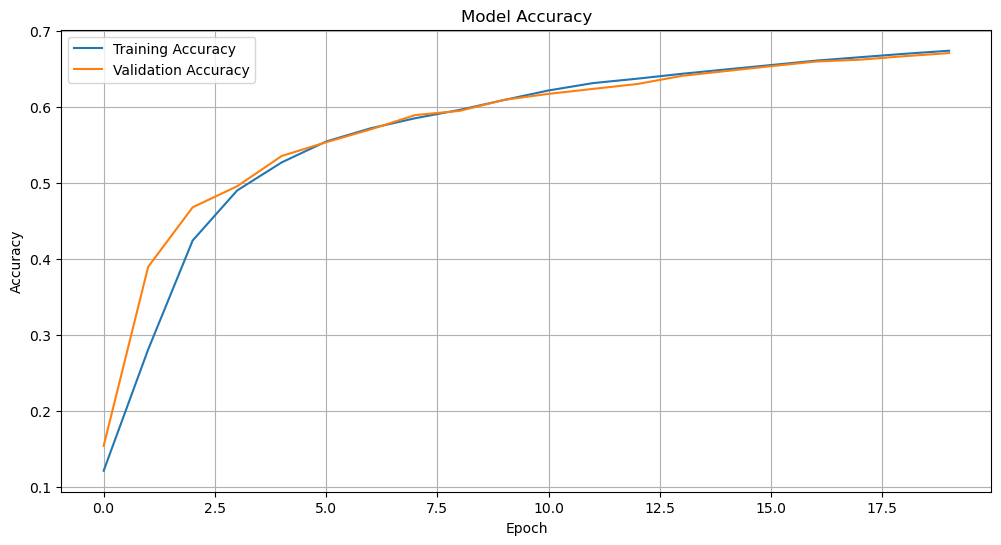

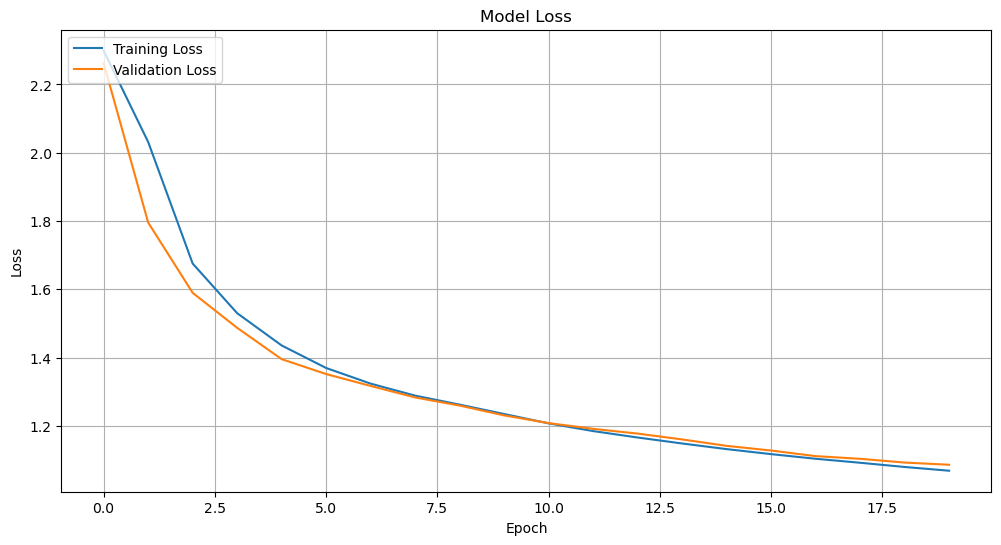

In [18]:
reset_seeds(seed=6)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

**Observations:_______**

**Model Accuracy:**
- The accuracy for both the training and testing are quite low at the begining (which is slightly above 10%). But it gets better afterward and we can see significance growth of accuracy from 10% to 67%. 
- Both the accuracy of training and testing shows similar pattern, indicating that there is no overfitting.

**Model Loss**
- The model loss for both the trainin and testing are also quite large at the begining, which is around 2.2, but it also improve afterward from 2.2 to 1.06.

- There is also no overfitting pattern shown in model loss.

Let's build one more model with higher complexity and see if we can improve the performance of the model. 

First, we need to clear the previous model's history from the Keras backend. Also, let's fix the seed again after clearing the backend.

In [19]:
reset_seeds(seed=6)

### **Second Model Architecture**
- Write a function that returns a sequential model with the following architecture:
 - First hidden layer with **256 nodes and the relu activation** and the **input shape = (1024, )**
 - Second hidden layer with **128 nodes and the relu activation**
 - Add the **Dropout layer with the rate equal to 0.2**
 - Third hidden layer with **64 nodes and the relu activation**
 - Fourth hidden layer with **64 nodes and the relu activation**
 - Fifth hidden layer with **32 nodes and the relu activation**
 - Add the **BatchNormalization layer**
 - Output layer with **activation as 'softmax' and number of nodes equal to the number of classes, i.e., 10**
 -Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.0005), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the nn_model_2 function and store the model in a new variable.
- Print the summary of the model.
- Fit on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 30**. Store the model building history to use later for visualization.

### **Build and train the new ANN model as per the above mentioned architecture**

In [20]:
reset_seeds(seed=6)

def nn_model_2():
    model = Sequential()
    model.add(Input(shape = (1024,)))
    model.add(Dense(256,activation = 'relu'))
    model.add(Dense(128,activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64,activation = 'relu'))
    model.add(Dense(64,activation = 'relu'))
    model.add(Dense(32,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(10,activation = 'softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
    
model_2 = nn_model_2()
print(model_2.summary())

# fit the train data
history_2 = model_2.fit(X_train_flattened, y_train_encode, 
                    validation_split=0.2, 
                    batch_size=128, 
                    epochs=20, 
                    verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 310,250 (1.18 MB)

 Trainable params: 310,186 (1.18 MB)

 Non-trainable params: 64 (256.00 B)

None
Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0997 - loss: 2.3712 - val_accuracy: 0.0999 - val_loss: 2.3099
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1001 - loss: 2.3051 - val_accuracy: 0.1230 - val_loss: 2.2924
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1908 - loss: 2.1474 - val_accuracy: 0.3551 - val_loss: 1.8672
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4378 - loss: 1.6207 - val_accuracy: 0.5285 - val_loss: 1.3985
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5468 - loss: 1.3513 - val_accuracy: 0.5968 - val_loss: 1.2136
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5904 - loss: 1.2329 - val_accuracy: 0.6264 - val_loss: 1.1339
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6216 - loss: 1.1572 - val_accuracy: 0.6231 - val_loss: 1.1357
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6406 - loss: 1.1085 - val_accurac

### **Plot the Training and Validation Accuracies and write down your Observations.**

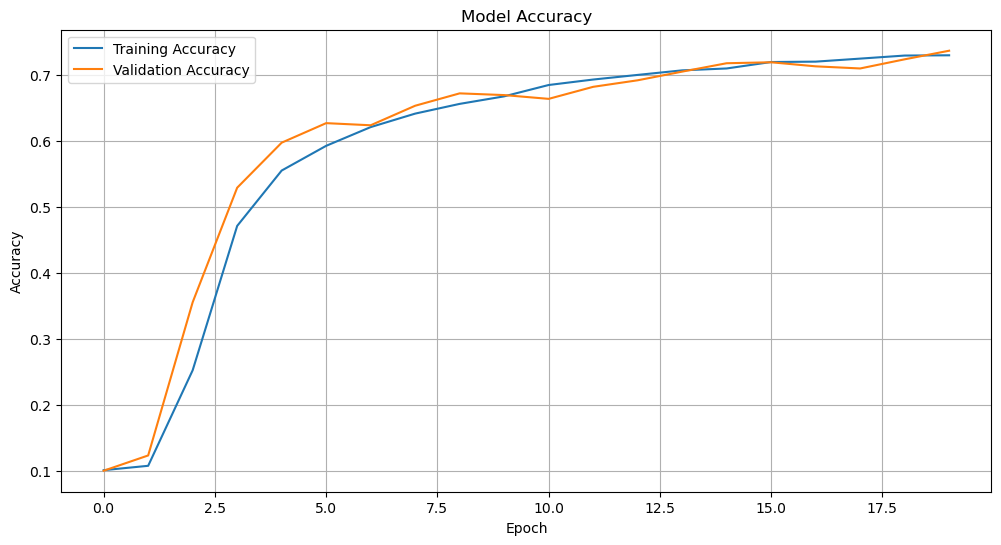

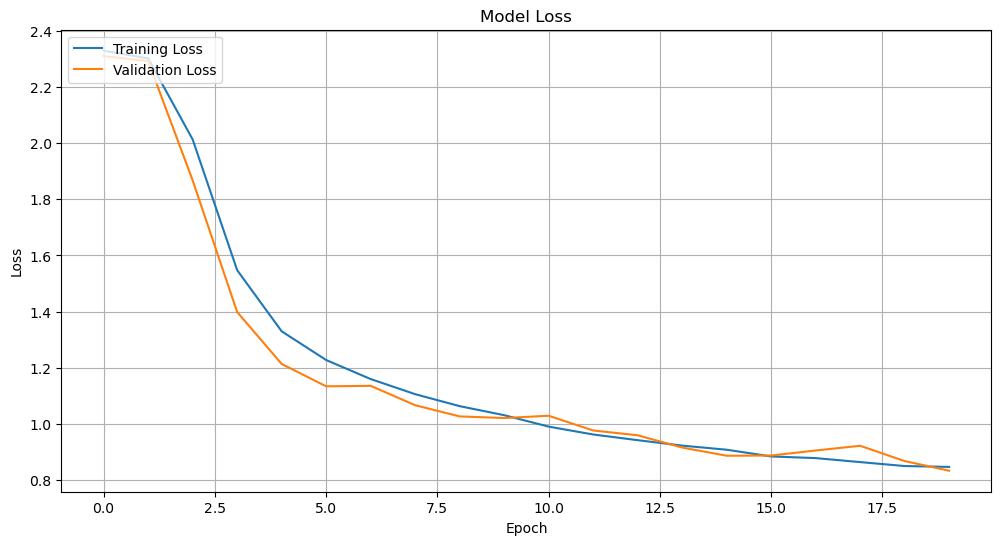

In [21]:
reset_seeds(seed=6)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

**Observations:_______**

**Model Accuracy:**
- Comparing to the first model, the second model shows a better accuracy (over 70%).
- There is no overfitting pattern shown.

**Model Loss**
- Comparing to the first model, the seocnd model also shows a lower loss (from 1.2 to lower than 0.8

## **Predictions on the test data**

- Make predictions on the test set using the second model.
- Print the obtained results using the classification report and the confusion matrix.
- Final observations on the obtained results.

In [22]:
y_pred = model_2.predict(X_test_flattened)

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step


**Note:** Earlier, we noticed that each entry of the target variable is a one-hot encoded vector but to print the classification report and confusion matrix, we must convert each entry of y_test to a single label.

In [23]:
# using argmax to convert one-hot encoded back to original labels
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_encode, axis=1)

### **Print the classification report and the confusion matrix for the test predictions. Write your observations on the final results.**

In [24]:
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.72      0.76      1204
           1       0.73      0.77      0.75      1190
           2       0.80      0.75      0.78      1214
           3       0.72      0.67      0.70      1180
           4       0.79      0.80      0.80      1204
           5       0.72      0.68      0.70      1202
           6       0.75      0.70      0.73      1216
           7       0.72      0.80      0.76      1217
           8       0.63      0.72      0.67      1210
           9       0.72      0.74      0.73      1163

    accuracy                           0.74     12000
   macro avg       0.74      0.74      0.74     12000
weighted avg       0.74      0.74      0.74     12000



In [25]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
        stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label' + stats_text if sum_stats else 'Predicted Label')

    if title:
        plt.title(title)

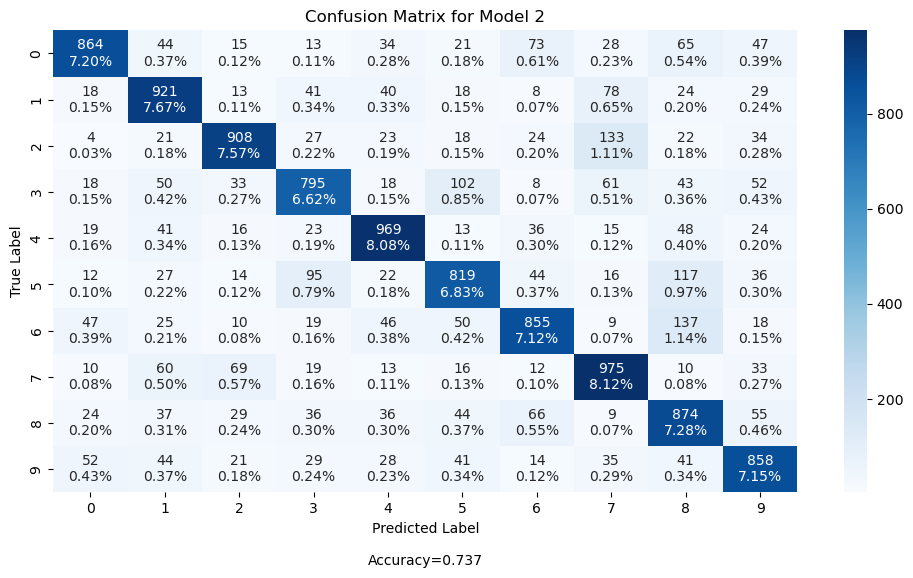

In [26]:
cf_matrix = confusion_matrix(y_true, y_pred)


# Define category names (optional)
categories = [str(i) for i in range(10)]

# Plot the confusion matrix
make_confusion_matrix(cf_matrix, 
                      categories=categories,
                      title='Confusion Matrix for Model 2',
                     figsize = (12,6))

**Final Observations:__________**

- The overall accuracy of model 2 on pridicting the testing data is 73.7%.
- The model achieves a high precision and F1-score for most digits, especially for digits 1, 2, 4, and 7.
- Digits like 5 and 8 have lower precision and recall, indicating room for improvement.
- The confusion matrix shows that the model performs well on most digits, with high accuracy for digits like 0, 1, 2, and 4.
- Misclassifications are more frequent for digits 5 and 8, as seen from the off-diagonal values.

## **Using Convolutional Neural Networks**

### **Load the dataset again and split the data into the train and the test dataset.**

In [27]:
# Split to train and test dataset
train_df, test_df = train_test_split(df,test_size = 0.2,random_state = 6)

# Creating the training and testing dataset
X_train = [image for image, label in train_df]
y_train = [label for image, label in train_df]
X_test = [image for image, label in test_df]
y_test = [label for image, label in test_df]

# Transfer into array format
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

Check the number of images in the training and the testing dataset.

Number of training samples: 48000


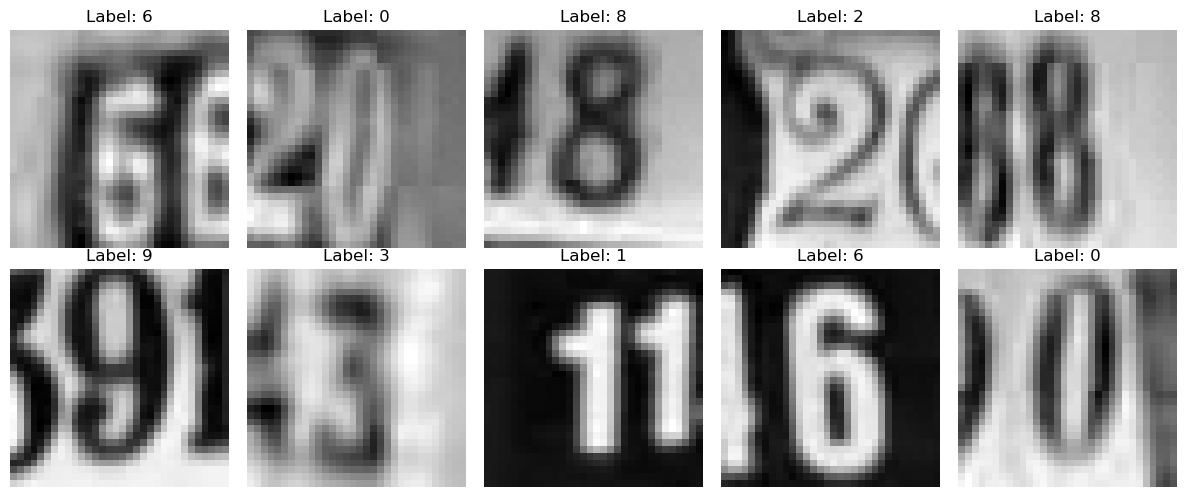

In [28]:
print(f"Number of training samples: {len(X_train)}")

# Visualize the first 10 images from training with their labels
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(X_train[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Label: {y_train[i]}")

plt.tight_layout()
plt.show()

Number of testing samples: 12000


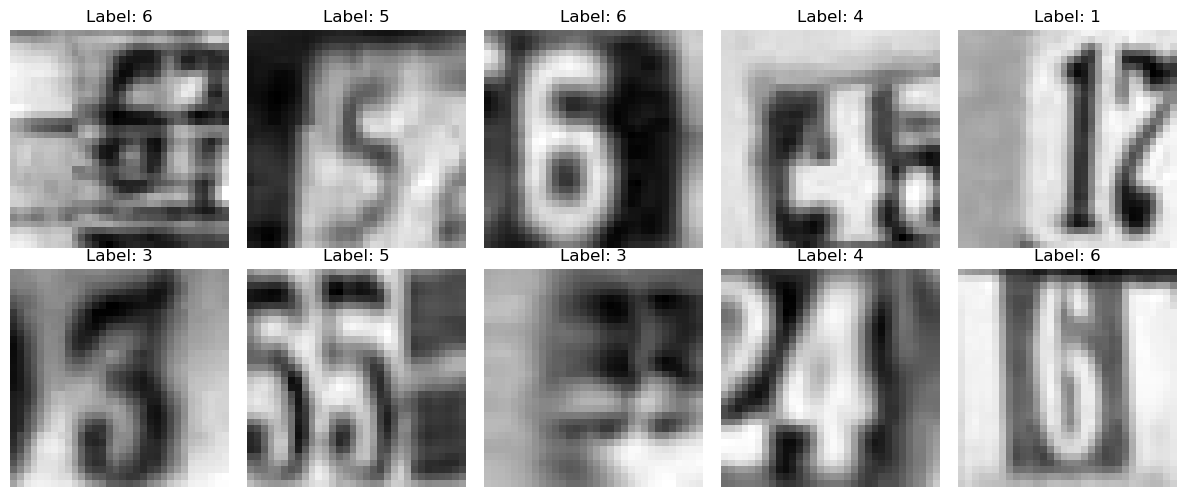

In [29]:
print(f"Number of testing samples: {len(X_test)}")

# Visualize the first 10 images from testing with their labels
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i in range(10):
    axes[i].imshow(X_test[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Label: {y_test[i]}")

plt.tight_layout()
plt.show()

**Observation:**


## **Data preparation**

- Print the shape and the array of pixels for the first image in the training dataset.
- Reshape the train and the test dataset because we always have to give a 4D array as input to CNNs.
- Normalize the train and the test dataset by dividing by 255.
- Print the new shapes of the train and the test dataset.
- One-hot encode the target variable.

In [30]:
print("Shape of the 1st image in training: ", X_train[0].shape)

Shape of the 1st image in training:  (32, 32)


Reshape the dataset to be able to pass them to CNNs. Remember that we always have to give a 4D array as input to CNNs

In [31]:
X_train_reshaped = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], 32, 32, 1)

Normalize inputs from 0-255 to 0-1

In [32]:
X_train_norm = X_train_reshaped.astype('float32') / 255.0
X_test_norm = X_test_reshaped.astype('float32') / 255.0

Print New shape of Training and Test

In [33]:
print(f"New shape of X_train: {X_train_norm.shape}")
print(f"New shape of X_test: {X_test_norm.shape}")

New shape of X_train: (48000, 32, 32, 1)
New shape of X_test: (12000, 32, 32, 1)


### **One-hot encode the labels in the target variable y_train and y_test.**

In [34]:
y_train_encode = to_categorical(y_train, num_classes=10)
y_test_encode = to_categorical(y_test, num_classes=10)

**Observation:**


## **Model Building**

Now that we have done data preprocessing, let's build a CNN model.
Fix the seed for random number generators

In [35]:
reset_seeds(seed=6)

### **Model Architecture**
- **Write a function** that returns a sequential model with the following architecture:
 - First Convolutional layer with **16 filters and the kernel size of 3x3**. Use the **'same' padding** and provide the **input shape = (32, 32, 1)**
 - Add a **LeakyRelu layer** with the **slope equal to 0.1**
 - Second Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Another **LeakyRelu** with the **slope equal to 0.1**
 - A **max-pooling layer** with a **pool size of 2x2**
 - **Flatten** the output from the previous layer
 - Add a **dense layer with 32 nodes**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add the final **output layer with nodes equal to the number of classes, i.e., 10** and **'softmax' as the activation function**
 - Compile the model with the **loss equal to categorical_crossentropy, optimizer equal to Adam(learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the function cnn_model_1 and store the output in a new variable.
- Print the summary of the model.
- Fit the model on the training data with a **validation split of 0.2, batch size = 32, verbose = 1, and epochs = 20**. Store the model building history to use later for visualization.

### **Build and train a CNN model as per the above mentioned architecture.**

In [36]:
reset_seeds(seed=6)
# Function to define the CNN model
def cnn_model_1():
    model = Sequential()
    model.add(Input(shape = (32,32,1)))
    model.add(Conv2D(16, (3, 3), padding='same'))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Call the function and store the output in a new variable
model_1_cnn = cnn_model_1()

# Print the summary of the model
print(model_1_cnn.summary())

# Fit the model on the training data
history_1_cnn = model_1_cnn.fit(X_train_norm, y_train_encode, 
                        validation_split=0.2, 
                        batch_size=32, 
                        epochs=20, 
                        verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       262,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,306 (1.02 MB)

 Trainable params: 267,306 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4402 - loss: 1.5814 - val_accuracy: 0.8300 - val_loss: 0.6021
Epoch 2/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8356 - loss: 0.5698 - val_accuracy: 0.8506 - val_loss: 0.5320
Epoch 3/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8647 - loss: 0.4747 - val_accuracy: 0.8630 - val_loss: 0.4918
Epoch 4/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.8800 - loss: 0.4113 - val_accuracy: 0.8689 - val_loss: 0.4767
Epoch 5/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.8961 - loss: 0.3593 - val_accuracy: 0.8691 - val_loss: 0.4876
Epoch 6/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.9078 - loss: 0.3169 - val_accuracy: 0.8685 - val_loss: 0.5014
Epoch 7/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9170 - loss: 0.2827 - val_accuracy: 0.8646 - val_loss: 0.5299
Epoch 8/20
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.9257 -

### **Plot the Training and Validation Accuracies and Write your observations.**

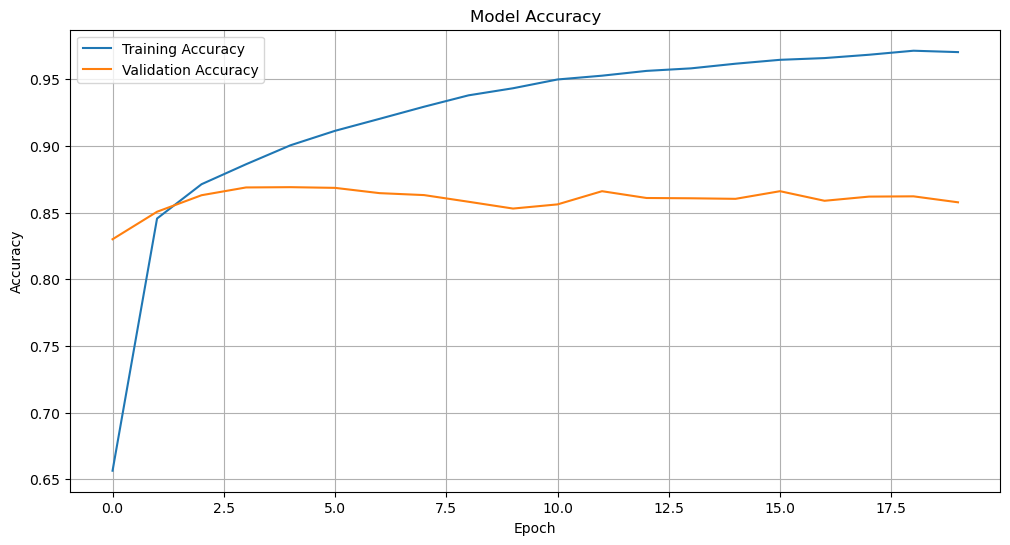

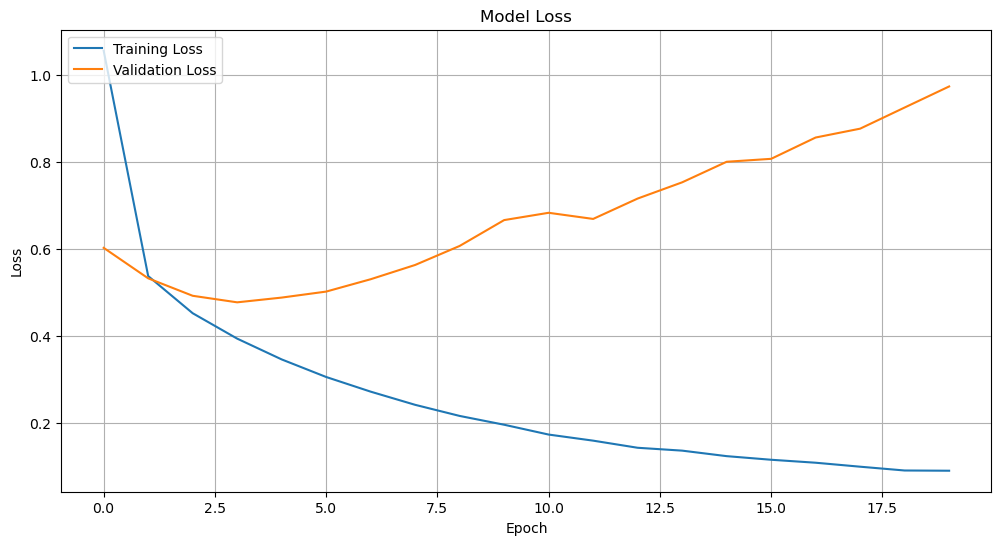

In [37]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history_1_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_1_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history_1_cnn.history['loss'], label='Training Loss')
plt.plot(history_1_cnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

**Observations:__________**

- The result of the 1st CNN models shows a obvious 'overfitting' trend since the performance of training is getting more better while that of testing is not.
- The accuracy on testing is comparatively much higher than the training and remain at around 85%. As for the loss, the testing shows a trend of increasing loss.


Let's build another model and see if we can get a better model with generalized performance.

First, we need to clear the previous model's history from the Keras backend. Also, let's fix the seed again after clearing the backend.

In [38]:
reset_seeds(seed=6)

### **Second Model Architecture**

- Write a function that returns a sequential model with the following architecture:
 - First Convolutional layer with **16 filters and the kernel size of 3x3**. Use the **'same' padding** and provide the **input shape = (32, 32, 1)**
 - Add a **LeakyRelu layer** with the **slope equal to 0.1**
 - Second Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Add **LeakyRelu** with the **slope equal to 0.1**
 - Add a **max-pooling layer** with a **pool size of 2x2**
 - Add a **BatchNormalization layer**
 - Third Convolutional layer with **32 filters and the kernel size of 3x3 with 'same' padding**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Fourth Convolutional layer **64 filters and the kernel size of 3x3 with 'same' padding** 
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add a **max-pooling layer** with a **pool size of 2x2**
 - Add a **BatchNormalization layer**
 - **Flatten** the output from the previous layer
 - Add a **dense layer with 32 nodes**
 - Add a **LeakyRelu layer with the slope equal to 0.1**
 - Add a **dropout layer with the rate equal to 0.5**
 - Add the final **output layer with nodes equal to the number of classes, i.e., 10** and **'softmax' as the activation function**
 - Compile the model with the **categorical_crossentropy loss, adam optimizers (learning_rate = 0.001), and metric equal to 'accuracy'**. Do not fit the model here, just return the compiled model.
- Call the function cnn_model_2 and store the model in a new variable.
- Print the summary of the model.
- Fit the model on the train data with a **validation split of 0.2, batch size = 128, verbose = 1, and epochs = 30**. Store the model building history to use later for visualization.

### **Build and train the second CNN model as per the above mentioned architecture.**

In [39]:
reset_seeds(seed=6)
# Function to define the CNN model
def cnn_model_2():
    model = Sequential()
    model.add(Input(shape = (32,32,1)))
    model.add(Conv2D(16, (3, 3), padding='same'))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(32))
    model.add(LeakyReLU(negative_slope=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Call the function and store the output in a new variable
model_2_cnn = cnn_model_2()

# Print the summary of the model
print(model_2_cnn.summary())

# Fit the model on the training data
history_2_cnn = model_2_cnn.fit(X_train_norm, y_train_encode, 
                        validation_split=0.2, 
                        batch_size=128, 
                        epochs=30, 
                        verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       131,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,362 (642.04 KB)

 Trainable params: 164,170 (641.29 KB)

 Non-trainable params: 192 (768.00 B)

None
Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.3019 - loss: 1.9949 - val_accuracy: 0.5320 - val_loss: 1.5217
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.7794 - loss: 0.7129 - val_accuracy: 0.8517 - val_loss: 0.4956
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.8318 - loss: 0.5527 - val_accuracy: 0.8719 - val_loss: 0.4589
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.8566 - loss: 0.4782 - val_accuracy: 0.8752 - val_loss: 0.4474
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.8694 - loss: 0.4366 - val_accuracy: 0.8856 - val_loss: 0.4050
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.8820 - loss: 0.3952 - val_accuracy: 0.8924 - val_loss: 0.3792
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.8853 - loss: 0.3735 - val_accuracy: 0.8964 - val_loss: 0.3598
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.8931 - loss: 0.34

### **Plot the Training and Validation accuracies and write your observations.**

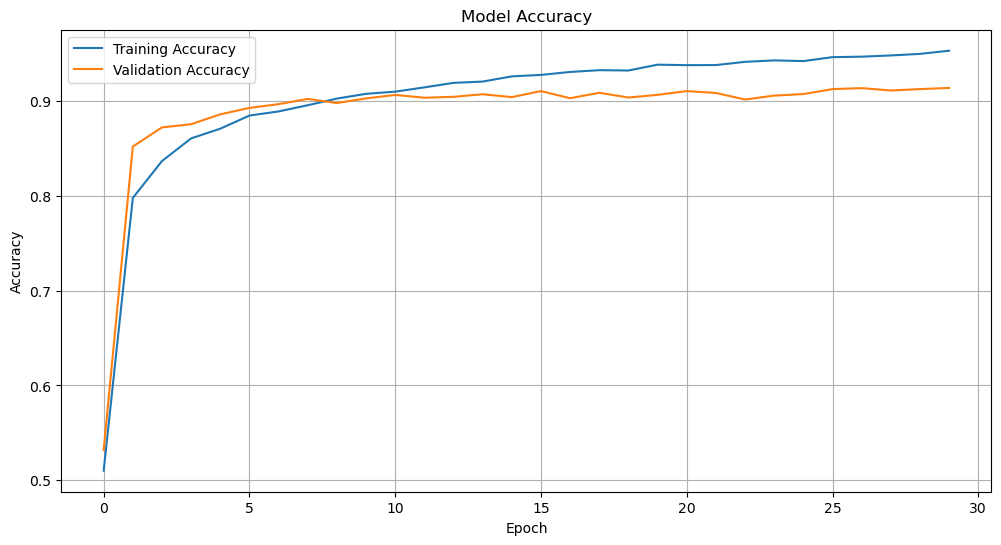

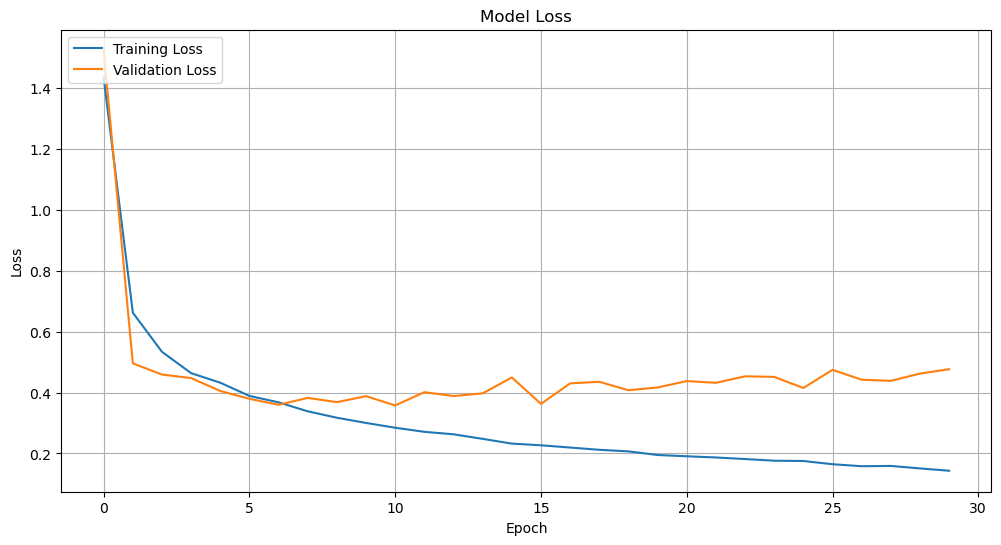

In [40]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history_2_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_2_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history_2_cnn.history['loss'], label='Training Loss')
plt.plot(history_2_cnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

**Observations:________**

- Overall, the 2nd CNN model has better performance than the 1st one, especially this time the model does not show overfitting.
- Both the training and testing show accuracy of more than 90+. This is a great increase.
- As for the model loss, both the training and testing shows downward trending, though it's a bit fluntuate for the testing.

## **Predictions on the test data**

- Make predictions on the test set using the second model.
- Print the obtained results using the classification report and the confusion matrix.
- Final observations on the obtained results.

### **Make predictions on the test data using the second model.** 

In [41]:
y_pred_probs_2 = model_2_cnn.predict(X_test_norm)
y_pred_2 = np.argmax(y_pred_probs_2, axis=1)
y_true_2 = np.argmax(y_test_encode, axis=1)

375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


**Note:** Earlier, we noticed that each entry of the target variable is a one-hot encoded vector, but to print the classification report and confusion matrix, we must convert each entry of y_test to a single label.

In [42]:
print("Classification Report for CNN Model 2:")
print(classification_report(y_true_2, y_pred_2))

Classification Report for CNN Model 2:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1204
           1       0.89      0.92      0.91      1190
           2       0.94      0.93      0.93      1214
           3       0.90      0.92      0.91      1180
           4       0.93      0.92      0.93      1204
           5       0.90      0.93      0.92      1202
           6       0.91      0.88      0.89      1216
           7       0.93      0.94      0.94      1217
           8       0.93      0.87      0.90      1210
           9       0.91      0.91      0.91      1163

    accuracy                           0.92     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.92      0.92     12000



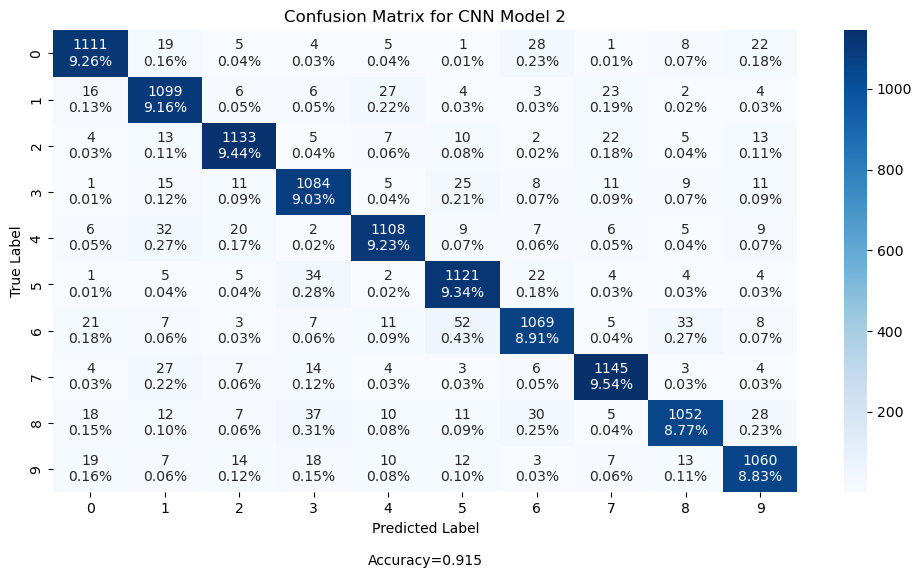

In [43]:
cf_matrix_2 = confusion_matrix(y_true_2, y_pred_2)

# Define category names (optional)
categories = [str(i) for i in range(10)]

# Plot the confusion matrix
make_confusion_matrix(cf_matrix_2, 
                      categories=categories,
                      title='Confusion Matrix for CNN Model 2',
                     figsize = (12,6))

### **Write your final observations on the performance of the model on the test data.**

**Final Observations:_________**

- The chosen CNN model has an accuracy of 91.5%, which is far more better than the chosen ANN model.
- Within the predicted label, "Label 6" seems to have the poorest correct prediction comparing to others, followed by "Label 8". We can provide model with more specific label data to improve the overall performance.
- The confusion matrix shows that the model performs exceptionally well on most digits, with high accuracy for digits 0, 1, 2, 3, 4, 5, 7, and 9.
- Misclassifications are relatively low across all digits, indicating robust performance.
- The model achieves high precision and F1-scores for all digits, particularly excelling in digits like 2, 4, and 7.
- The lowest performance is seen in digit 6, though it still maintains a high level of accuracy.

# Conclusion for Final Model:

After thoroughly evaluating the performance of both Artificial Neural Networks (ANNs) and Convolutional Neural Networks (CNNs) on the SVHN dataset, we have chosen CNN Model 2 as the final solution for the following reasons:

- **Superior Accuracy:** CNN Model 2 achieved an overall accuracy of 91.5%, which is significantly higher compared to the ANN models and CNN Model 1. This indicates a stronger ability to generalize from the training data to unseen test data.
- **Enhanced Performance Metrics:** The precision, recall, and F1-scores for CNN Model 2 are consistently high across all digit classes. This uniform performance across classes is crucial for applications requiring high reliability and accuracy.
- **Robust Confusion Matrix:** The confusion matrix for CNN Model 2 shows low misclassification rates, indicating that the model correctly identifies digits with high confidence and minimal errors. This robustness is essential for practical deployment where accuracy is critical.
- **Advanced Architectural Features:** CNN Model 2 includes additional convolutional layers, batch normalization, and dropout layers, which contribute to its superior performance. These architectural enhancements help in capturing complex patterns in the image data and reducing overfitting.